In [1]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1


In [3]:
CSV_PATH = os.path.join(path, "UrbanSound8K.csv")

TARGET_DURATION = 4.0
SAMPLE_RATE = 22050

In [4]:
metadata = pd.read_csv(CSV_PATH)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
label_dict = metadata.groupby("classID")["class"].first().to_dict()
label_dict

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [6]:
def load_audio_file(row, target_duration=TARGET_DURATION, sr=SAMPLE_RATE):
    fold = f"fold{row['fold']}"
    filename = row['slice_file_name']
    file_path = os.path.join(path, fold, filename)

    y, _ = librosa.load(file_path, sr=sr)

    target_length = int(sr * target_duration)

    if len(y) > target_length:
        y = y[:target_length]
    else:
        y = np.pad(y, (0, target_length - len(y)), mode='constant')

    return y

In [7]:
folds = [{} for _ in range(10)]  # fold1 ~ fold10

for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
    fold_idx = row["fold"] - 1
    filename = row["slice_file_name"]
    label = row["classID"]
    
    y = load_audio_file(row)

    folds[fold_idx][filename] = {
        "data": y,
        "label": label
    }

100%|██████████| 8732/8732 [00:50<00:00, 172.67it/s]


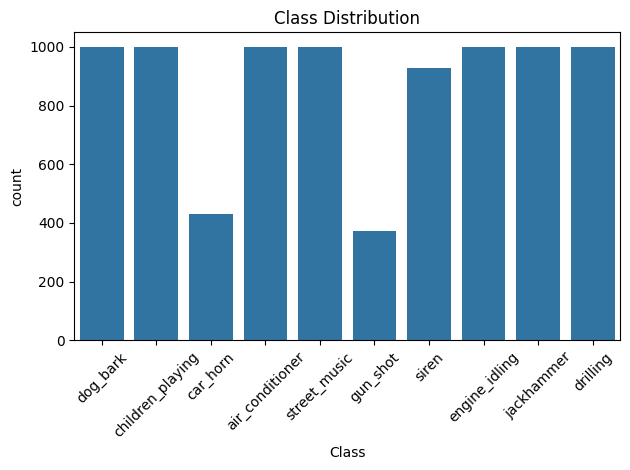

In [8]:
sns.countplot(x=metadata['classID'].map(label_dict))
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

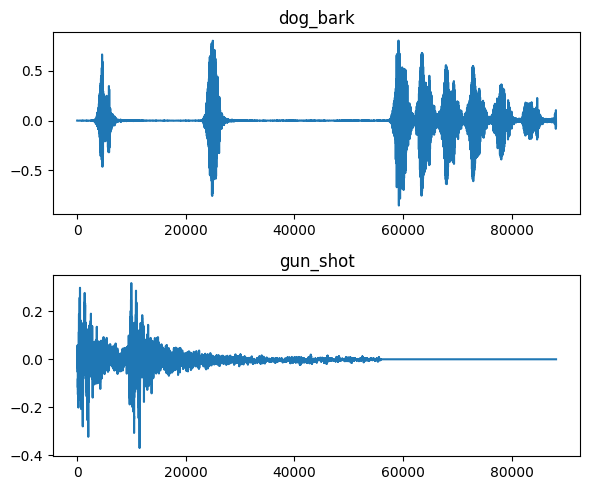

In [9]:
sample_data_1 = folds[0]['101415-3-0-2.wav']
sample_data_2 = folds[0]['102305-6-0-0.wav']

plt.figure(figsize=(6, 5))

plt.subplot(2, 1, 1)
plt.plot(sample_data_1['data'])
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
plt.plot(sample_data_2['data'])
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()


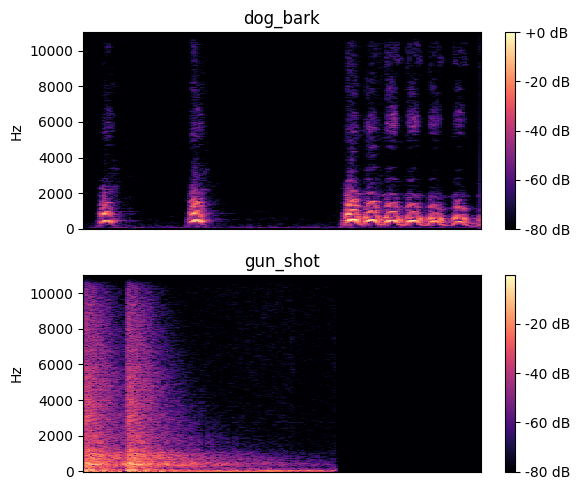

In [10]:
plt.figure(figsize=(6, 5))

plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_1['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_2['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

In [ ]:
dir = "../data"
if not os.path.exists(dir):
	os.mkdir(dir)

pickle.dump(folds, open('../data/folds.pkl', 'wb'))
pickle.dump(label_dict, open('../data/label_dict.pkl', 'wb'))